# 1、多GPU从零实现

In [1]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

以简单的LeNet网络为例子

In [3]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4] # 可学习的参数

def lenet(X, params): # 定义LeNet网络
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

loss = nn.CrossEntropyLoss(reduction='none') # 交叉熵损失函数

下面是本次练习的重点：向多个设备分发参数

In [5]:
def get_params(params, device): # 将训练参数和设备名传入
    new_params = [p.clone().to(device) for p in params] # 将每个参数放到指定的设备上（也就是你想指定哪个gpu），这里的clone就是克隆一份到gpu
    for p in new_params:
        p.requires_grad_() # 将每个参数设置成看可训练的，也就是可求梯度
    return new_params

new_params = get_params(params, d2l.try_gpu(0)) # 使用0号gpu

# 打印看看
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


allreduce 函数将所有向量相加，并将结果广播给所有 GPU

In [6]:
def allreduce(data): # 这个data包含gpu的信息，也就是说第0维度，是gpu的编号
    """这个函数就是将2，3，4gpu上的数据，先复制到1gpu上，然后再做相加操作"""
    for i in range(1, len(data)): # 先放在0号gpu上，做相加
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)): # 然后再复制回去
        data[i] = data[0].to(data[i].device)

data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


将一个小批量数据均匀地分布在多个 GPU 上

In [9]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:0')] # 我这里只有一个gpu，要是多个，那就继续写
split = nn.parallel.scatter(data, devices) # 利用scatter函数将data(tensor形式)均匀切割，到指定的多个gpu上
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=0)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'))


In [11]:
def split_batch(X, y, devices):
    """将`X`和`y`拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices)) # 利用scatter函数将data(tensor形式)均匀切割，到指定的多个gpu上

在一个小批量上实现多 GPU 训练

In [12]:
def train_batch(X, y, device_params, devices, lr):
    """
    device_params:所有gpu上的参数
    devices:有哪些gpu
    """
    X_shards, y_shards = split_batch(X, y, devices) # 切割成小批量，均匀分配到每个gpu上
    ls = [loss(lenet(
        X_shard, device_W),
        y_shard).sum() 
          for X_shard, y_shard, device_W in zip(
                 X_shards, y_shards, device_params)] # 这个是让每个gpu计算自己那个批量上的loss
    for l in ls: # 对每个gpu做backwark()
        l.backward()
    with torch.no_grad():
        for i in range(len(device_params[0])): # 把所有的gpu上的梯度放到一个上面，然后加起来，再给每个gpu送入，这样每个gpu上最终的梯度就是整个小批量完整的梯度
            allreduce([device_params[c][i].grad 
                       for c in range(len(devices))])
    for param in device_params: # 每个gpu做自己的sgd
        d2l.sgd(param, lr, X.shape[0])

定义训练函数

In [13]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)] # 指定用几个gpu
    device_params = [get_params(params, d) for d in devices] # 将参数复制到每个gpu上，每个gpu拿到的梯度是一样的
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize() # 同步，作用是算时间
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

在单个GPU上运行

test acc: 0.83, 3.2 sec/epoch on [device(type='cuda', index=0)]


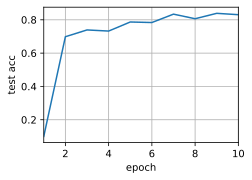

In [14]:
train(num_gpus=1, batch_size=256, lr=0.2)

增加为2个GPU

ValueError: Expected a non cpu device, but got: cpu

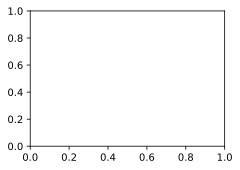

In [16]:
train(num_gpus=2, batch_size=256, lr=0.2) # 我这里只有一个，所以报错了

# 2、多GPU的简洁实现

In [2]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
from d2l import torch as d2l

以简单的resnet18网络为例子：

In [3]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的 ResNet-18 模型。"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(
                    d2l.Residual(in_channels, out_channels, use_1x1conv=True,
                                 strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64), nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module("fc",
                   nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    return net

net = resnet18(10)
devices = d2l.try_all_gpus()

训练

In [4]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)] # 指定使用几个gpu

    def init_weights(m): # 初始化训练参数
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)

    net.apply(init_weights) # 应用初始化参数
    net = nn.DataParallel(net, device_ids=devices) # 把每个params复制到每个gpu上，再把梯度加起来（就是前面从零实现的那些操作都包含了）
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

在单个GPU上训练网络

test acc: 0.89, 44.2 sec/epoch on [device(type='cuda', index=0)]


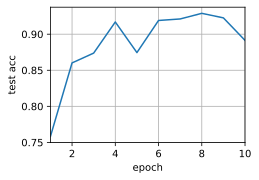

In [5]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

使用 2 个 GPU 进行训练

In [7]:
train(net, num_gpus=2, batch_size=512, lr=0.2) # 因为我只有一个gpu所以报错了

ValueError: Expected a non cpu device, but got: cpu